In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import splitfolders
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers
from keras.losses import SparseCategoricalCrossentropy
from keras.models import load_model

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [ ]:
splitfolders.ratio(
    "Potato_Diseases_Dataset",
     output="Potato_Diseases_Dataset_split",
     ratio=(.8, .1, .1)
)

Copying files: 2152 files [00:35, 59.84 files/s] 


In [3]:
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=360,
    channel_shift_range=30
)

trainDataset = datagen.flow_from_directory(
    'Potato_Diseases_Dataset_split/train',
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
)

validationDataset = datagen.flow_from_directory(
    'Potato_Diseases_Dataset_split/val',
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
)

testDataset = datagen.flow_from_directory(
    'Potato_Diseases_Dataset_split/test',
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
)

classNames = list(trainDataset.class_indices.keys())

Found 1721 images belonging to 3 classes.
Found 215 images belonging to 3 classes.
Found 216 images belonging to 3 classes.


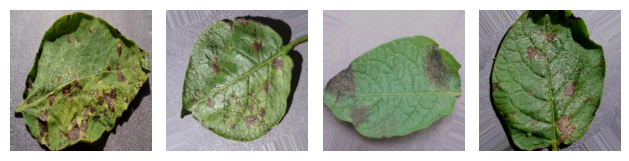

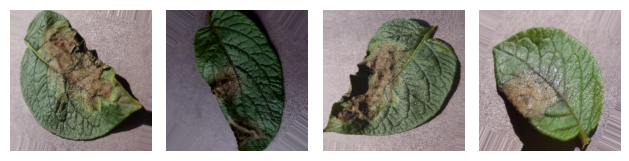

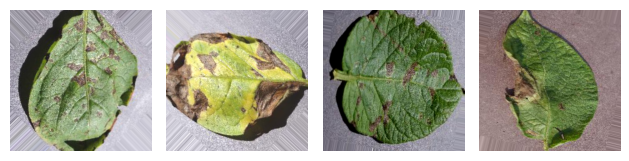

In [ ]:
# Get the total number of images in the dataset
total_images = 12  # Update the number of images you want to display

# Define the number of columns and rows for displaying the images
num_columns = 4  # Number of images per row
num_rows = total_images // num_columns  # Number of rows

# Iterate over the generator and display each augmented image
for i in range(num_rows):
    # Generate the next batch of augmented images
    batch = next(trainDataset)

    # Get the batch of augmented images
    images = batch[0]

    # Rescale the images to the original range
    augmented_images = (images * 255.0).astype(np.uint8)

    # Create a new figure for each row
    plt.figure()

    # Display each augmented image in the row
    for j in range(num_columns):
        augmented_image = augmented_images[j]

        # Display the augmented image in a subplot
        plt.subplot(1, num_columns, j + 1)
        plt.imshow(augmented_image)
        plt.axis('off')

    # Adjust the layout and spacing between subplots
    plt.tight_layout()

    # Show the row of augmented images
    plt.show()

In [ ]:
len(trainDataset)

54

In [ ]:
len(validationDataset)

7

In [ ]:
len(testDataset)

7

In [6]:
# Define the input shape and number of classes
inputShape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # Input shape of the images
numClasses = 3                                  # Number of classes in the classification task
growth_rate = 32        # Number of filters added in each layer of the dense block
num_filters = 64  # Initial number of filters
num_layers = [6, 12, 16, 8]  # Number of layers in each dense block
num_blocks = 4  # Number of dense blocks

# Initial convolutional layer
inputs = layers.Input(shape=inputShape)                        # Input layer
x = layers.Conv2D(num_filters, kernel_size=(7, 7), strides=(2, 2), padding='same')(inputs)  # Initial convolution
x = layers.BatchNormalization()(x)                              # Batch normalization
x = layers.Activation('relu')(x)                                # ReLU activation
x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)  # Max pooling


for block in range(num_blocks):

    # Dense block
    for layer in range(num_layers[block]):

        # Convolution block
        x = layers.BatchNormalization()(x)          # Batch normalization
        x = layers.Activation('relu')(x)            # ReLU activation
        x = layers.Conv2D(growth_rate, kernel_size=(3, 3), padding='same')(x)  # 3x3 Convolution

        # Resize inputs to match the shape of x
        resized_inputs = layers.Conv2D(growth_rate, kernel_size=(1, 1))(inputs)  # 1x1 Convolution
        resized_inputs = tf.image.resize(resized_inputs, (x.shape[1], x.shape[2]))  # Resize to match x
        x = layers.concatenate([x, resized_inputs])  # Concatenate with previous layers

        num_filters += growth_rate  # Update the number of filters

    # Transition block
    if block != num_blocks - 1:
        x = layers.BatchNormalization()(x)        # Batch normalization
        x = layers.Activation('relu')(x)          # ReLU activation
        x = layers.Conv2D(num_filters, kernel_size=(1, 1))(x)  # 1x1 Convolution
        x = layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)  # Average pooling

# Classification head
x = layers.GlobalAveragePooling2D()(x)      # GlobalAveragePooling
x = layers.Dense(1000, activation='relu')(x)  # Dense layer with 1000 units and ReLU activation
outputs = layers.Dense(numClasses, activation='softmax')(x)  # Output layer with softmax activation

# Create the model
model = models.Model(inputs=inputs, outputs=outputs)

# Display the model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_120 (Conv2D)            (None, 128, 128, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_62 (BatchN  (None, 128, 128, 64  256        ['conv2d_120[0][0]']             
 ormalization)                  )                                                           

In [7]:
model.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [8]:
history = model.fit(
    trainDataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    epochs=EPOCHS,
    steps_per_epoch=53,
    validation_data=validationDataset,
    validation_steps=6,
    verbose=1
)

Epoch 1/50
53/53 [==============================] - 338s 5s/step - loss: 0.4288 - accuracy: 0.8342 - val_loss: 1.3998 - val_accuracy: 0.4479
Epoch 2/50
53/53 [==============================] - 49s 915ms/step - loss: 0.2333 - accuracy: 0.9106 - val_loss: 0.8069 - val_accuracy: 0.6667
Epoch 3/50
53/53 [==============================] - 48s 908ms/step - loss: 0.2188 - accuracy: 0.9189 - val_loss: 3.4233 - val_accuracy: 0.4688
Epoch 4/50
53/53 [==============================] - 49s 917ms/step - loss: 0.1755 - accuracy: 0.9402 - val_loss: 7.9357 - val_accuracy: 0.4479
Epoch 5/50
53/53 [==============================] - 49s 910ms/step - loss: 0.1695 - accuracy: 0.9361 - val_loss: 2.1234 - val_accuracy: 0.5677
Epoch 6/50
53/53 [==============================] - 50s 922ms/step - loss: 0.1917 - accuracy: 0.9290 - val_loss: 1.1684 - val_accuracy: 0.8021
Epoch 7/50
53/53 [==============================] - 49s 927ms/step - loss: 0.1293 - accuracy: 0.9544 - val_loss: 0.6020 - val_accuracy: 0.8542
E

In [ ]:
model.save('DenseNet_Model4.h5')

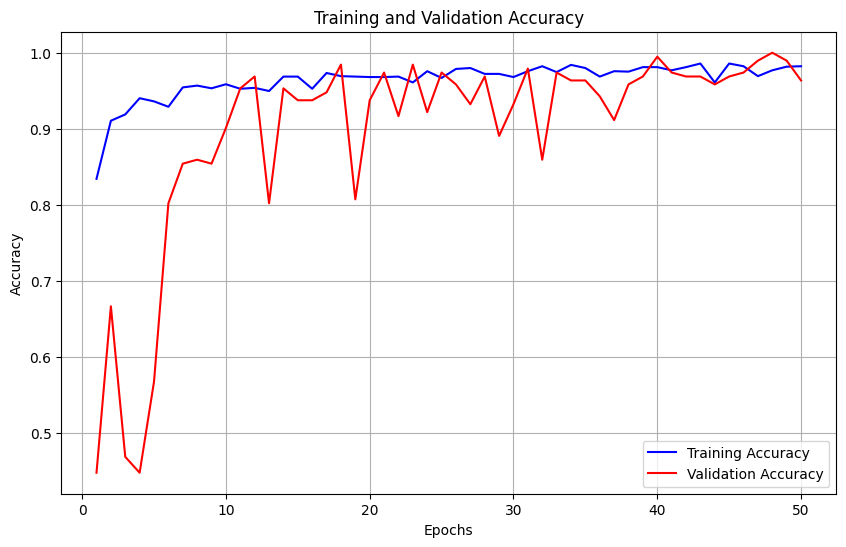

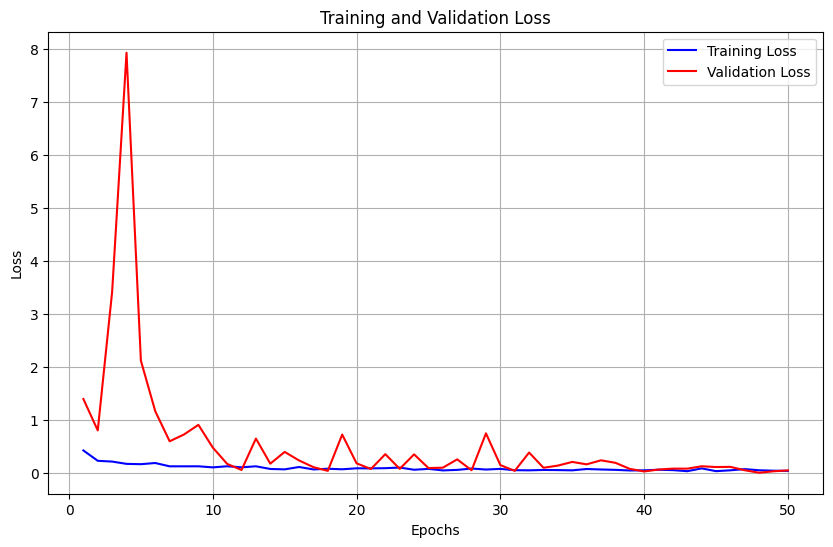

In [10]:
# Extracting accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)  # Generating a range of values for the epochs (starting from 1)

# Plotting training and validation accuracy
plt.figure(figsize=(10, 6))  # Adjusting the figure size for better visualization
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)  # Adding a grid for better readability
plt.show()

# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(testDataset)

# Print the final accuracy
print("Final Accuracy on Test Data: {:.2f}%".format(test_accuracy * 100))

7/7 [==============================] - 48s 8s/step - loss: 0.0660 - accuracy: 0.9815
Final Accuracy on Test Data: 98.15%


In [4]:
model = load_model('DenseNet_Model.h5')

1/1 [==============================] - 5s 5s/step


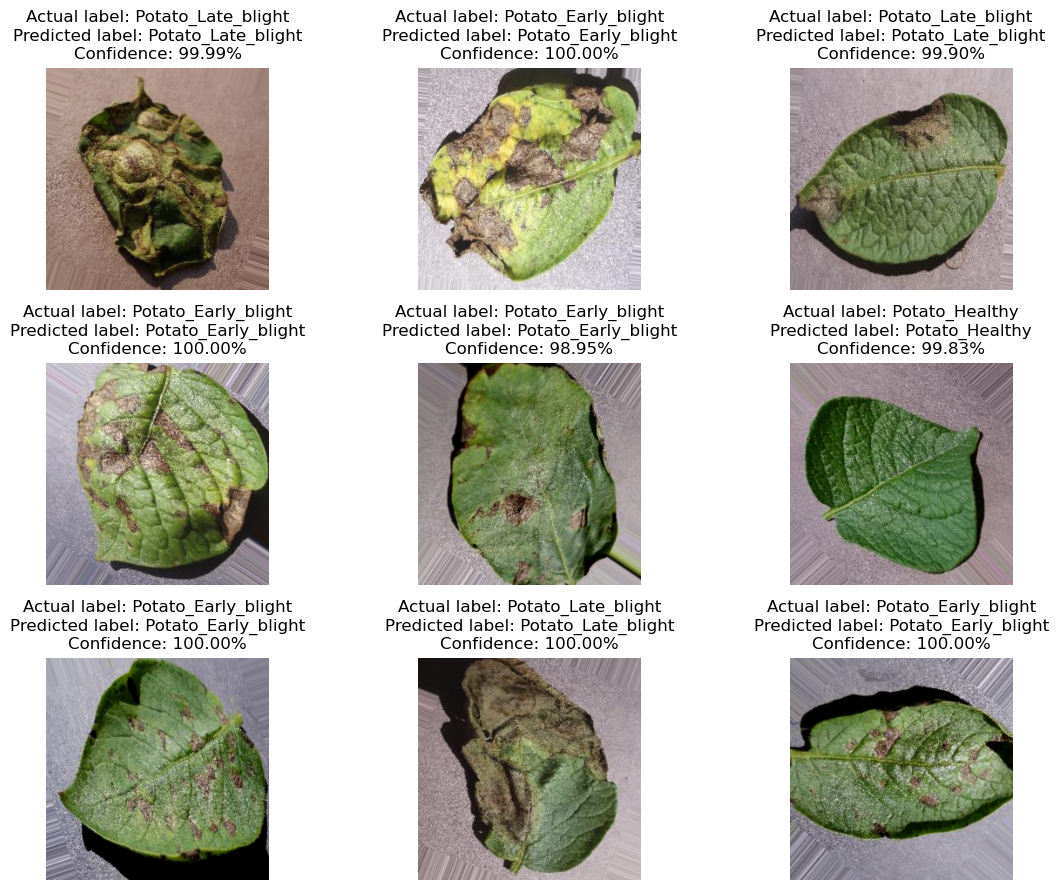

In [13]:
num_images_per_row = 3  # Number of images to display in each row
num_images_to_display = 9  # Total number of images to display
num_rows = (num_images_to_display + num_images_per_row - 1) // num_images_per_row  # Calculate the number of rows

fig, axs = plt.subplots(num_rows, num_images_per_row, figsize=(12, 3*num_rows))
axs = axs.flatten()

counter = 0  # To keep track of the number of images displayed

for image_batch, label_batch in testDataset:
    batch_predictions = model.predict(image_batch)

    for i in range(len(image_batch)):
        if counter >= num_images_to_display:
            break

        image = image_batch[i]
        label = int(label_batch[i])
        confidence = np.max(batch_predictions[i]) * 100  # Model confidence for the predicted label

        axs[counter].imshow(image)
        axs[counter].set_title("Actual label: " + classNames[label] +
                               "\nPredicted label: " + classNames[np.argmax(batch_predictions[i])] +
                               "\nConfidence: {:.2f}".format(confidence)+"%")  # Print the confidence value
        axs[counter].axis("off")

        counter += 1

    if counter >= num_images_to_display:
        break

# Hide any remaining empty subplots
for i in range(counter, len(axs)):
    axs[i].axis("off")

plt.tight_layout()
plt.show()